# Домашнее задание 3 [10 баллов] 
# До 30.04.18 23:59

Задание выполняется в группе (1-4 человека). В случае использования какого-либо строннего источника информации обязательно дайте на него ссылку (поскольку другие тоже могут на него наткнуться). Плагиат наказывается нулём баллов за задание и предвзятым отношением в будущем.

Не все части обязательны для выполнения, однако вы можете быть дополнительно оштрафованы за небрежное за выполнение одной или двух частей вместо четырех.

При возниконовении проблем с выполнением задания обращайтесь с вопросами к преподавателю. Поэтому настоятельно рекомендуется выполнять задание заранее, оставив запас времени на всевозможные технические проблемы. Если вы начали читать условие в последний вечер и не успели из-за проблем с установкой какой-либо библиотеки — это ваши проблемы.


Результат выполнения задания — это отчёт в формате html на основе Jupyter Notebook. Нормальный отчёт должен включать в себя:
* Краткую постановку задачи и формулировку задания
* Описание **минимума** необходимой теории и/или описание используемых инструментов - не стоит переписывать лекции или Википедию
* Подробный пошаговый рассказ о проделанной работе
* Аккуратно оформленные результаты
* **Внятные выводы** – не стоит относится к домашнему заданию как к последовательности сугубо технических шагов, а стоит относится скорее как к небольшому практическому исследованию, у которого есть своя цель и свое назначение.

Небрежное его оформление отчета существенно отразится на итоговой оценке. Весь код из отчёта должен быть воспроизводимым, если для этого нужны какие-то дополнительные действия, установленные модули и т.п. — всё это должно быть прописано в тексте в явном виде.

Сдача отчетов осуществляется через систему AnyTask.



## Использование архитектуры SENNA для определения части речи

Домашнее задание написано по мотивам работы R. Collobert:

**Collobert, Ronan, Jason Weston, Léon Bottou, Michael Karlen, Koray Kavukcuoglu, and Pavel Kuksa. "Natural language processing (almost) from scratch." Journal of Machine Learning Research 12, no. Aug (2011): 2493-2537.**

В этом домашнем задании вам предстоит самостоятельно разработать архитектуру SENNA для определения части речи. 
SENNA – это простая архитектура нейронной сети, позволяющая достигнуть state-of-the-art результатов в нескольких задачах обработки текстов.  

Использование SENNA для определения части речи предполагает, что задача определения части речи для данного слова формулируется как задача классификации: пусть в размеченном корпусе всего $|T|$ (= tagset) различных тегов частей речи, тогда каждое слово $w$ относится к одному из $T$ классов. Для каждого слова из обучающих данных формируется собственный вектор признаков. Нейронная сеть обучается по всем векторам признаков для слов из обучающего множества. 

Подход к решению задачи классификации представлен в оригинальной статье на рис. 1 (Figure 1: Window approach network). Он состоит из следующих шагов (раздел 3.3.1):
1. Каждое слово представляется эмбеддингом: $w_i \rightarrow LT_{w^i}$, размерность эмбеддинга - $d$;
2. Для каждого слова формируется окно длины $k$ из $(k-1)/2$ соседних слов слева от данного слова  и $(k-1)/2$ соседних слов справа от данного слова, $k$ – нечетное. 
3. Для каждого слова формируется вектор признаков, состоящий из конкатенированных эмбеддингов слов из левого окна, данного слова и слов из правого окна. Итоговая размерность вектора признаков – $d \times k$. Именно этот вектор подается на вход нейронной сети;
4. Обучается нейронная сеть, имеющая один скрытый слой с $n_h$ нейроннами и нелинейной функцией активации $\theta$;
5. На выходном слое нейронной сети решается задача классификации на |T| классов, то есть, определяется часть речи для каждого слова. 

Если для слова невозможно найти $(k-1)/2$ соседних слов слева от данного слова  и $(k-1)/2$ соседних слов справа от данного слова – используется padding.


### Данные
1. Открытый корпус: https://github.com/dialogue-evaluation/morphoRuEval-2017/blob/master/OpenCorpora_Texts.rar
2. Предобученные эмбеддинги Facebook: https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.ru.vec

### Часть 1 [2 балла] Подготовка данных
1. Прочитайте размеченные данные Открытого корпуса, используя nltk.corpus.reader.conll.ConllCorpusReader
2. Посчитайте количество предложений и число тегов частей речи;
3. Сформируйте тестовое и обучающее множество: первые 3/4 данных – обучающее множество;

Для каждого слова:
1. Определите его окно (слова слева и справа) размера $k$;
2. Сформируйте его вектор признаков.

In [1]:
# Читаем корпус, считаем простейшие статистики.

from nltk.corpus.reader.conll import ConllCorpusReader


data_reader = ConllCorpusReader('./data', fileids='unamb_sent_14_6.conllu',
                                columntypes=['ignore', 'words', 'ignore', 'pos', 'chunk'])
sentences = list(data_reader.iob_sents())
pos_tags = [pos for sentence in sentences for word, pos, chunk in sentence]
pos_tag_set = set(pos_tags)
pos_tag_to_num = {tag: num for num, tag in enumerate(pos_tag_set)}

print(f'Количество предложений: {len(sentences)}')
print(f'Количество различных POS-тегов: {len(pos_tag_to_num)}')

Количество предложений: 38508
Количество различных POS-тегов: 14


In [2]:
# Делим предложения из корпуса на две группы: для обучающей и тестовой выборки.

import random


TRAIN_PERCENT = 0.75

random.shuffle(sentences)
sentences_train_size = int(TRAIN_PERCENT * len(sentences))
sentences_train, sentences_test = sentences[:sentences_train_size], sentences[sentences_train_size:]
print(f'Количество предложений в обучающей выборке: {len(sentences_train)}')
print(f'Количество предложений в тестовой выборке: {len(sentences_test)}')

Количество предложений в обучающей выборке: 28881
Количество предложений в тестовой выборке: 9627


In [3]:
%%time
# Загружаем fasttext модель, ограничиваясь первыми limit словами.

from gensim.models import KeyedVectors


fasttext_model = KeyedVectors.load_word2vec_format('wiki.ru.vec', limit=999999)

C:\Users\ASautin\AppData\Local\Continuum\Anaconda2\envs\con3.6\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Wall time: 4min


In [4]:
# Создаем функцию, формирующую вектор признаков для слова
# на основе его индекса в языковой модели и индексов его соседей.

import numpy as np


def make_feature_vector(sentence, window_size, word_idx, fasttext_model):
    window_half_size = (window_size - 1) // 2
    features = np.zeros((window_size,))
    idx_start = word_idx - window_half_size
    for idx in range(max(idx_start, 0), min(word_idx + window_half_size + 1, len(sentence))):
        word = sentence[idx][0].lower()
        word_in_vocab = fasttext_model.vocab.get(word, None)
        if word_in_vocab is not None:
            features[idx - idx_start] = word_in_vocab.index
    return features

In [5]:
# Создаем класс для набора параметров эксперимента, задаем параметры первого эксперимента.

from collections import namedtuple


ExperimentParams = namedtuple('ExperimentParams', ('window_size',
                                                   'hidden_layer_units',
                                                   'hidden_layer_activation'))
Metrics = namedtuple('Metrics', ('acc', 'val_acc'))

---
_Начиная отсюда и до части 4, код будет зависеть от конкретных параметров эксперимента._

In [6]:
# Формируем обучающую и тестовую выборки.
# Т.к. при обучении модели будет использоваться categorical_crossentropy loss,
# кодируем все метки классов с помощью one-hot-encoding.

from keras.utils import to_categorical


def prepare_data(sentences, window_size, fasttext_model, pos_tag_to_num):
    features = [make_feature_vector(sentence, window_size, idx, fasttext_model)
                for sentence in sentences for idx in range(len(sentence))]
    tags = [to_categorical(pos_tag_to_num[tag], len(pos_tag_to_num))
            for sentence in sentences for _, tag, _ in sentence]
    return np.array(features), np.array(tags)


PARAMS_INIT = ExperimentParams(window_size=5, hidden_layer_units=256, hidden_layer_activation='tanh')
words_train, tags_train = prepare_data(sentences_train, PARAMS_INIT.window_size, fasttext_model, pos_tag_to_num)
words_test, tags_test = prepare_data(sentences_test, PARAMS_INIT.window_size, fasttext_model, pos_tag_to_num)

Using TensorFlow backend.


### Часть 2 [4 баллов] Архитектура нейронной сети

Архитектура нейронной сети состоит из следующих слов:
1. Входной слой: нейронная сеть получает на вход вектор признаков, состоящий из $k$ конкатенированных эмбеддингов;/
2. Скрытый слой: $n_h$ нейронов и нелинейная функция активации $\theta$;
3. Выходной слой:  $|T|$ нейронов для итоговой классификации.

Обучите нейронную сеть на обучающих данных.

In [7]:
# Создаем модель классификатора, компилируем ее и выводим краткое описание.

from keras.layers import Input, Dense, Flatten
from keras.models import Model


def create_classifier_model(input_shape, hidden_layer_units, hidden_layer_activation,
                            class_count, fasttext_model):
    # Пользуемся функционалом gensim.KeyedVectors для создания слоя Embedding.
    # и инициализации его весами
    embedding_layer = fasttext_model.get_keras_embedding()
    # Также отмечаем, что эти веса не надо менять при обучении сети.
    embedding_layer.trainable = False

    input_layer = Input(input_shape)
    embedding = embedding_layer(input_layer)
    flattened = Flatten()(embedding)
    hidden = Dense(hidden_layer_units, activation=hidden_layer_activation)(flattened)
    output = Dense(class_count, activation='softmax')(hidden)
    return Model(inputs=[input_layer], outputs=[output])


classifier = create_classifier_model((PARAMS_INIT.window_size,),
                                     PARAMS_INIT.hidden_layer_units,
                                     PARAMS_INIT.hidden_layer_activation,
                                     len(pos_tag_to_num),
                                     fasttext_model)
classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 5, 300)            299999700 
_________________________________________________________________
flatten_1 (Flatten)          (None, 1500)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               384256    
_________________________________________________________________
dense_2 (Dense)              (None, 14)                3598      
Total params: 300,387,554
Trainable params: 387,854
Non-trainable params: 299,999,700
_________________________________________________________________


In [8]:
# Обучаем классификатор.
# Сохраняем лог обучения и веса модели.

import json


def make_experiment_name(params):
    return ','.join([f'window_{params.window_size}',
                     f'units_{params.hidden_layer_units}',
                     f'act_{params.hidden_layer_activation}'])


def train_model(model, data_train, data_validation, epochs, name='main', verbose=1):
    history = classifier.fit(data_train[0], data_train[1], epochs=epochs, validation_data=data_validation, verbose=verbose)
    with open(f'logs/{name}.json', 'w') as fout:
        json.dump(history.history, fout, sort_keys=True, indent=4)
    classifier.save_weights(f'weights/{name}')
    return Metrics(acc=history.history['acc'][-1], val_acc=history.history['val_acc'][-1])


metrics = train_model(classifier, (words_train, tags_train), (words_test, tags_test),
                      epochs=10, name=make_experiment_name(PARAMS_INIT))
RESULTS = {PARAMS_INIT: metrics}

Train on 343662 samples, validate on 113921 samples
Epoch 1/10
343662/343662 [==============================] - 39s 113us/step - loss: 0.2453 - acc: 0.9224 - val_loss: 0.1863 - val_acc: 0.9383
Epoch 2/10
343662/343662 [==============================] - 38s 112us/step - loss: 0.1535 - acc: 0.9498 - val_loss: 0.1663 - val_acc: 0.9466
Epoch 3/10
343662/343662 [==============================] - 39s 112us/step - loss: 0.1177 - acc: 0.9611 - val_loss: 0.1663 - val_acc: 0.9483
Epoch 4/10
343662/343662 [==============================] - 38s 112us/step - loss: 0.0928 - acc: 0.9689 - val_loss: 0.1681 - val_acc: 0.9484
Epoch 5/10
343662/343662 [==============================] - 38s 112us/step - loss: 0.0745 - acc: 0.9750 - val_loss: 0.1696 - val_acc: 0.9508
Epoch 6/10
343662/343662 [==============================] - 38s 112us/step - loss: 0.0603 - acc: 0.9797 - val_loss: 0.1784 - val_acc: 0.9495
Epoch 7/10
343662/343662 [==============================] - 39s 113us/step - loss: 0.0502 - acc: 0.983

### Часть 3 [1 балл] Оценка качества

Протестируйте нейронную сеть на тестовых данных. Используйте accuracy для оценки качества модели.

In [9]:
# В еще одном прогоне тестовых данных через модель нет необходимости,
# т.к. accuracy на нем уже был посчитан в конце последней эпохи.
# Тем не менее, продемонстрирую, что я умею это делать. :)

metrics_values = classifier.evaluate(words_test, tags_test)
for metric_name, metric_value in zip(classifier.metrics_names, metrics_values):
    print(f'{metric_name}: {metric_value}')

113921/113921 [==============================] - ETA:  - 5s 46us/step
loss: 0.22058031487945634
acc: 0.948771517103958


In [10]:
import keras.backend as K


K.clear_session()

### Часть 4 [1 балл] Оптимизация гиперпарметров

В эксперименте участвуют следующие гиперпараметры:
* $k$ – размер окна;
* $n_h$ – число нейронов на скрытом слое;
* $\theta$ – вид функции активации.

Оцените их влияние на качество модели.

In [11]:
# Перебираем параметры по сетке.
# Для каждого набора параметров (при изменении размера окна)
# заново генерируем обучающую и тестовую выборки,
# обучаем сеть и сохраняем accuracy с последней эпохи в словарь RESULTS.
import itertools

window_sizes = [1, 3, 5, 7]
hidden_layer_units_counts = [64, 128, 256, 512]
hidden_layer_activations = ['relu', 'tanh']

for window_size in window_sizes:
    words_train, tags_train = prepare_data(sentences_train, window_size, fasttext_model, pos_tag_to_num)
    words_test, tags_test = prepare_data(sentences_test, window_size, fasttext_model, pos_tag_to_num)

    for hidden_layer_units, hidden_layer_activation in itertools.product(hidden_layer_units_counts,
                                                                         hidden_layer_activations):
        params = ExperimentParams(window_size, hidden_layer_units, hidden_layer_activation)
        if params == PARAMS_INIT:
            continue
        classifier = create_classifier_model((window_size,),
                                             hidden_layer_units,
                                             hidden_layer_activation,
                                             len(pos_tag_to_num),
                                             fasttext_model)
        classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        metrics = train_model(classifier, (words_train, tags_train), (words_test, tags_test),
                              epochs=10, name=make_experiment_name(params), verbose=0)
        RESULTS[params] = metrics
        print(params)
        print(metrics)
        print()
        K.clear_session()

ExperimentParams(window_size=1, hidden_layer_units=64, hidden_layer_activation='relu')
Metrics(acc=0.93457234142849666, val_acc=0.92651925457115014)

ExperimentParams(window_size=1, hidden_layer_units=64, hidden_layer_activation='tanh')
Metrics(acc=0.93447631684793797, val_acc=0.93046058233337137)

ExperimentParams(window_size=1, hidden_layer_units=128, hidden_layer_activation='relu')
Metrics(acc=0.93812234114028803, val_acc=0.93176850624555618)

ExperimentParams(window_size=1, hidden_layer_units=128, hidden_layer_activation='tanh')
Metrics(acc=0.93745307889867613, val_acc=0.93005679374303241)

ExperimentParams(window_size=1, hidden_layer_units=256, hidden_layer_activation='relu')
Metrics(acc=0.93987988197844641, val_acc=0.9327340876572362)

ExperimentParams(window_size=1, hidden_layer_units=256, hidden_layer_activation='tanh')
Metrics(acc=0.93770623461563063, val_acc=0.9315578339375532)

ExperimentParams(window_size=1, hidden_layer_units=512, hidden_layer_activation='relu')
Metrics(ac

**Как увеличение окна влияет на итоговый показатель качества?**

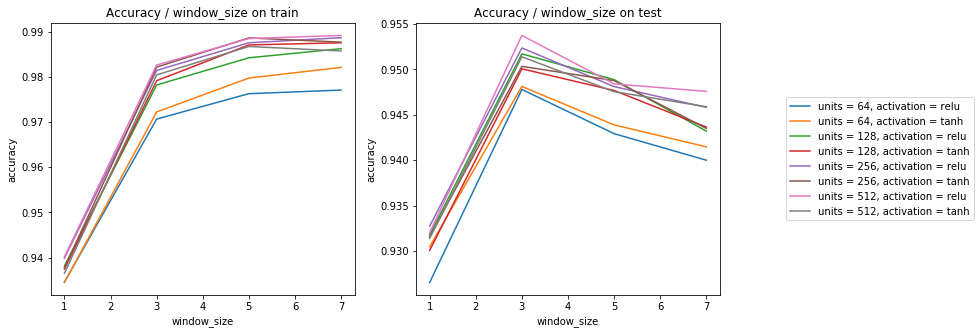

In [55]:
from matplotlib import pyplot as plt

xs = window_sizes
ys_train, ys_val = [[] for _ in xs], [[] for _ in xs]
for unit_count in hidden_layer_units_counts:
    for activation in hidden_layer_activations:
        for idx, x in enumerate(xs):
            metrics = RESULTS[ExperimentParams(window_size=x,
                                               hidden_layer_units=unit_count,
                                               hidden_layer_activation=activation)]
            ys_train[idx].append(metrics.acc)
            ys_val[idx].append(metrics.val_acc)
ys_train, ys_val = np.array(ys_train), np.array(ys_val)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((12, 5)))
axes[0].set_title('Accuracy / window_size on train')
axes[1].set_title('Accuracy / window_size on test')

axes[0].set(xlabel='window_size', ylabel='accuracy')
axes[1].set(xlabel='window_size', ylabel='accuracy')

axes[0].plot(xs, ys_train)
axes[1].plot(xs, ys_val)

plt.legend([f'units = {units}, activation = {activation}'
            for units in hidden_layer_units_counts
            for activation in hidden_layer_activations], loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.show()

По графикам можно видеть, что наилучших результатов на тестовой выборке удалось добиться с окном ширины 3. При выборе окна ширины 1 трудно было ожидать хороших результатов, т.к. тогда при классификации никак не используется контекст слова (а такая задача может быть непростой и для человека в случае омонимии, например). При увеличении ширины окна до 5 и больше возрастает сложность данных (размерность входного вектора), с чем, предположительно, наша простая модель справляется хуже. Было бы интересно проверить это предположение, реализовав более сложную модель классификатора, пока же можно сказать, что окно ширины 3 является оптимальным для этой задачи.

**Как увеличение числа нейронов влияет на итоговый показатель качества?**

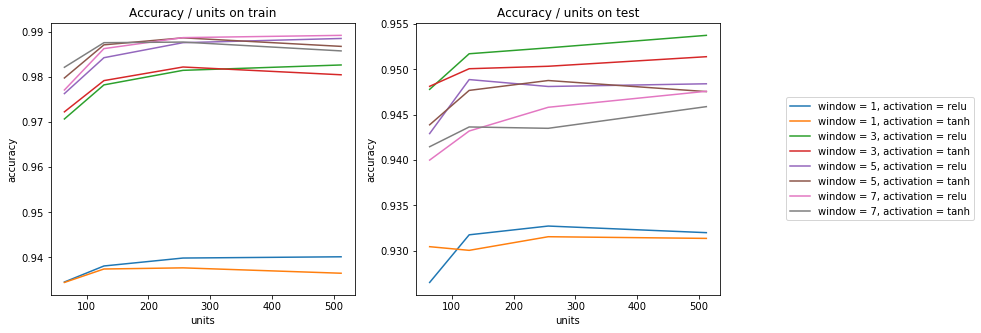

In [56]:
from matplotlib import pyplot as plt

xs = hidden_layer_units_counts
ys_train, ys_val = [[] for _ in xs], [[] for _ in xs]
for window_size in window_sizes:
    for activation in hidden_layer_activations:
        for idx, x in enumerate(xs):
            metrics = RESULTS[ExperimentParams(window_size=window_size,
                                               hidden_layer_units=x,
                                               hidden_layer_activation=activation)]
            ys_train[idx].append(metrics.acc)
            ys_val[idx].append(metrics.val_acc)
ys_train, ys_val = np.array(ys_train), np.array(ys_val)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((12, 5)))
axes[0].set_title('Accuracy / units on train')
axes[1].set_title('Accuracy / units on test')

axes[0].set(xlabel='units', ylabel='accuracy')
axes[1].set(xlabel='units', ylabel='accuracy')

axes[0].plot(xs, ys_train)
axes[1].plot(xs, ys_val)

plt.legend([f'window = {window}, activation = {activation}'
            for window in window_sizes
            for activation in hidden_layer_activations], loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.show()

Исходя из графиков, можно точно сказать, что 64 нейронов недостаточно для получения высокой точности (практически все графики испытывают резкий скачок после точки units=64). Далее графики ведут себя по-разному в зависимости от других параметров эксперимента, тем не менее в тех экспериментах, где на тестовой выборке были получены наивысшие результаты, наблюдается плавный рост точности модели с увеличением числа нейронов до точки units=256.

**Зависит ли итоговый показатель качества от функции активации на скрытом слое?**

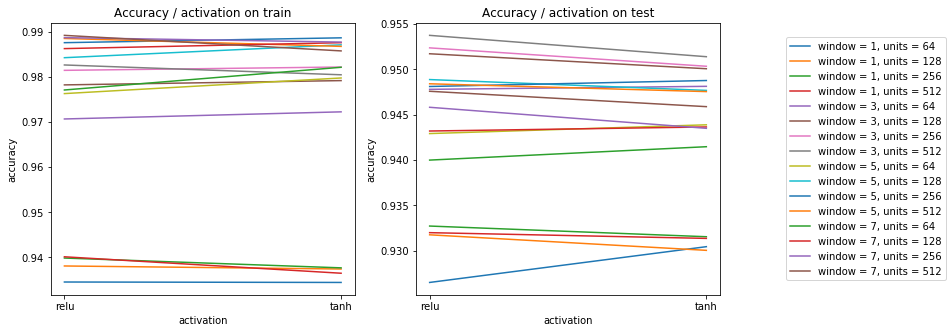

In [58]:
from matplotlib import pyplot as plt

x_ticks = hidden_layer_activations
xs = list(range(len(x_ticks)))
ys_train, ys_val = [[] for _ in xs], [[] for _ in xs]
for window_size in window_sizes:
    for unit_count in hidden_layer_units_counts:
        for idx, x in zip(xs, x_ticks):
            metrics = RESULTS[ExperimentParams(window_size=window_size,
                                               hidden_layer_units=unit_count,
                                               hidden_layer_activation=x)]
            ys_train[idx].append(metrics.acc)
            ys_val[idx].append(metrics.val_acc)
ys_train, ys_val = np.array(ys_train), np.array(ys_val)
plt.close()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((12, 5)))
axes[0].set_title('Accuracy / activation on train')
axes[1].set_title('Accuracy / activation on test')

axes[0].set(xlabel='activation', ylabel='accuracy')
axes[1].set(xlabel='activation', ylabel='accuracy')

axes[0].plot(xs, ys_train)
axes[1].plot(xs, ys_val)
plt.setp(axes, xticks=xs, xticklabels=x_ticks)

plt.legend([f'window = {window}, units = {units}'
            for window in window_sizes
            for units in hidden_layer_units_counts], loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.show()

По графикам кажется, что в большинстве случаев выбор функции активации на скрытом слое влиял на точность. Тем не менее, это влияние было преимущественно небольшим (порядка 0.1 процента), да и однозначно лучшей функции активации здесь выделить нельзя (в топовых экспериментах победила ReLU, в нескольких других -- tanh), поэтому, мне кажется, что различия в точности можно списать на другие причины (например, случайность инициализации весов полносвязных слоев).

### Часть 5 [2 балла] Анализ ошибок
1. Привидите примеры из тестового множества, на которых нейронная сеть ошибается. Объясните, почему возникают ошибки.
2. Протестируйте нейронную сеть на произвольном предложении (не из тестовых данных). Возникают ли ошибки? Почему?